# SASA

# setup and data loading

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from tabulate import tabulate
import py3Dmol

from dms_3d_features.sasa import compute_solvent_accessibility
from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    format_small_plot,
)

In [37]:
def r2(x, y):
    return pearsonr(x, y)[0] ** 2

In [38]:
DATA_PATH = "../data"

In [39]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
with np.errstate(divide="ignore"):
    df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
df = df.query("r_data_outlier == False").copy()
df_sasa = pd.read_csv(f"{DATA_PATH}/pdb-features/sasa.csv")
df_sasa["m_sequence"] = df_sasa["m_sequence"].apply(lambda x: x.replace("&", "_"))

# merge and remove extra pdb res
df_merge = pd.merge(df, df_sasa, on=["m_sequence", "r_nuc", "pdb_r_pos", "pdb_path"])
df_merge = df_merge.query("not ln_r_data.isnull()")

In [63]:
# Count unique combinations of m_sequence and pdb_r_pos
unique_combinations = (
    df_merge.groupby(["m_sequence", "pdb_r_pos"]).size().reset_index().shape[0]
)

print(
    f"Number of unique combinations of m_sequence and pdb_r_pos: {unique_combinations}"
)

Number of unique combinations of m_sequence and pdb_r_pos: 695


In [40]:
df.iloc[0]

m_sequence                                                             AAAC_GCU
r_nuc                                                                         A
pdb_r_pos                                                                     3
partner_nuc                                                                None
pdb_partner_pos                                                             NaN
r_type                                                                       WC
pdb_r_bp_type                                                               cWW
pdb_r_pair                                                                  A-U
no_of_conformations                                                           1
no_of_interactions                                                            1
no_of_partner_interactions                                                    1
pdb_name                                         TWOWAY.6NY2.1-2.GCU-AAAC.0.pdb
pdb_path                      data/pdbs_

# SASA for ideal cases

## free nucleotides

In [41]:
path = "../data/pdb-features/"
df_1 = compute_solvent_accessibility(f"{path}/c.pdb", probe_radius=0.5)
df_1.head()

FreeSASA: warning: atom '  C  C1*' unknown, guessing element is ' C', and radius 1.700 A


,pdb_path,m_sequence,r_nuc,pdb_r_pos,sasa
0,../data/pdb-features//c.pdb,pdb-features,C,3,21.840662


In [42]:
path = "../data/pdb-features/"
df_1 = compute_solvent_accessibility(f"{path}/a.pdb", probe_radius=0.5)
df_1.head()

FreeSASA: warning: atom '  A  C1*' unknown, guessing element is ' C', and radius 1.700 A


,pdb_path,m_sequence,r_nuc,pdb_r_pos,sasa
0,../data/pdb-features//a.pdb,pdb-features,A,2,19.033702


# Everything else

In [43]:
def visualize_molecule(row, width=400, height=300):
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(open("../" + row["pdb_path"], "r").read(), "pdb")

    # Set color scheme for nucleotides
    nucleotide_colors = {"A": "red", "U": "green", "C": "blue", "G": "orange"}
    for nuc, color in nucleotide_colors.items():
        viewer.setStyle({"resn": nuc}, {"stick": {"color": color}})

    viewer.zoomTo()

    residue_number = row["pdb_r_pos"]
    viewer.addStyle({"resi": str(residue_number)}, {"stick": {"color": "magenta"}})

    # Highlight N1 for A or N3 for C
    if row["r_nuc"] == "A":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N1"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )
    elif row["r_nuc"] == "C":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N3"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )

    return viewer


# Example usage:
viewer = visualize_molecule(df.loc[0])
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [44]:
df_merge.sort_values("sasa_0_5").iloc[0]

m_sequence                                                        GGGAGC_GGGAGC
r_nuc                                                                         C
pdb_r_pos                                                                     8
partner_nuc                                                                None
pdb_partner_pos                                                             NaN
r_type                                                                       WC
pdb_r_bp_type                                                               cWW
pdb_r_pair                                                                  C-G
no_of_conformations                                                           1
no_of_interactions                                                            1
no_of_partner_interactions                                                    1
pdb_name                                    TWOWAY.1D4R.4-4.GGGAGC-GGGAGC.0.pdb
pdb_path                      data/pdbs_

In [45]:
row = df_merge.sort_values("sasa_0_5").iloc[0]
viewer = visualize_molecule(row)
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## which SASA probe is best

In [46]:
sasa_columns = [c for c in df_merge.columns if "sasa" in c]
print(sasa_columns)

['sasa_0_1', 'sasa_0_25', 'sasa_0_5', 'sasa_1_0', 'sasa_1_5', 'sasa_2_0', 'sasa_2_5', 'sasa_3_0']


In [47]:
for c in sasa_columns:
    print(c, r2(df_merge[c], df_merge["ln_r_data"]))

sasa_0_1 0.3072878452193452
sasa_0_25 0.3721236259083129
sasa_0_5 0.4065110604621437
sasa_1_0 0.3330538540932488
sasa_1_5 0.2331428408748689
sasa_2_0 0.16898011377520988
sasa_2_5 0.12725435117151807
sasa_3_0 0.0992787863263245


## Overall relationships between SASA and reactivity

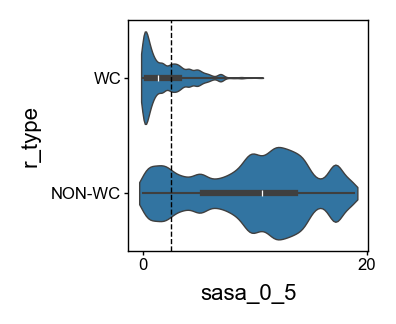

In [48]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = sns.violinplot(
    data=df_merge,
    x="sasa_0_5",
    y="r_type",
    density_norm="width",
    linewidth=0.5,
    cut=0.5,
    ax=ax,
)
ax.axvline(2.5, color="black", linestyle="--", linewidth=0.5)
format_small_plot(ax)

In [49]:
df_merge.groupby("r_type")["sasa_0_5"].agg([np.mean, np.std])

,mean,std
r_type,,
NON-WC,9.731553,5.189537
WC,2.023728,1.983471


In [50]:
r2(df_merge["sasa_0_5"], df_merge["ln_r_data"])

0.4065110604621437

In [51]:
df_non_wc = df_merge.query("r_type == 'NON-WC'").copy()
df_wc = df_merge.query("r_type == 'WC'").copy()

Text(0.5, 1.0, 'Density Plot of SASA vs ln(Reactivity)')

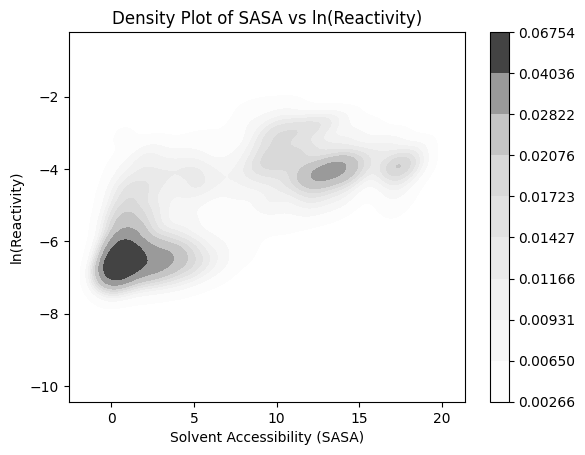

In [52]:
sns.kdeplot(
    data=df_merge, x="sasa_0_5", y="ln_r_data", fill=True, cmap="Greys", cbar=True
)
plt.xlabel("Solvent Accessibility (SASA)")
plt.ylabel("ln(Reactivity)")
plt.title("Density Plot of SASA vs ln(Reactivity)")

In [53]:
data = []
for i, group in df_merge.groupby(["m_sequence", "r_loc_pos"]):
    data.append([group["r_data"].mean(), group["sasa_0_5"].mean()])
df_avg = pd.DataFrame(data, columns=["r_data", "sasa_0_5"])
df_avg["ln_r_data"] = np.log(df_avg["r_data"])
df_avg["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

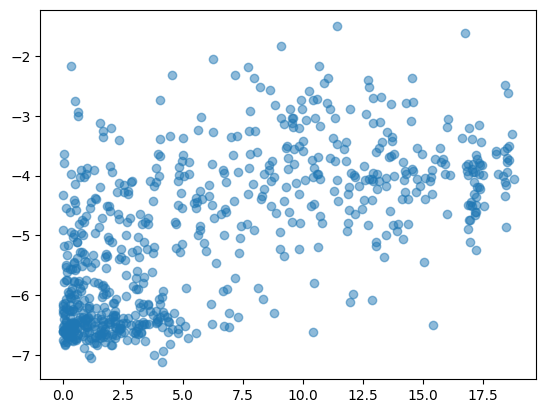

In [65]:
plt.scatter(df_avg["sasa_0_5"], df_avg["ln_r_data"], alpha=0.5)

# how do pairs effect SASA?

need to look at resolution to see how it changes it generally higher res structures seem to have lower SASA for pairs

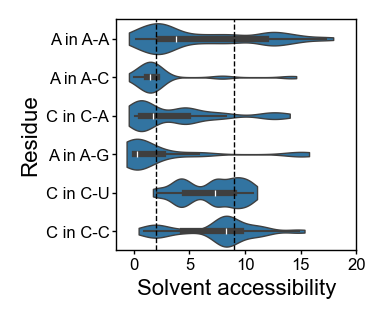

In [55]:
df_non_wc_pair = df_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
sns.violinplot(
    data=df_non_wc_pair,
    x="sasa_0_5",
    y="cat",
    density_norm="width",
    linewidth=0.5,
    cut=0.5,
    ax=ax,
)
ax.axvline(2, color="black", linestyle="--", linewidth=0.5)
ax.axvline(9, color="black", linestyle="--", linewidth=0.5)

format_small_plot(ax)
ax.set_xlabel("Solvent accessibility", labelpad=2)
ax.set_ylabel("Residue", labelpad=2)
ax.set_xticks([0, 5, 10, 15, 20])

In [56]:
def calculate_sasa_percentages(df_non_wc_pair, sasa_thresholds=[2, 4, 6]):
    results = []
    for threshold in sasa_thresholds:
        below_threshold = (
            df_non_wc_pair[df_non_wc_pair["sasa_0_5"] < threshold].groupby("cat").size()
        )
        total = df_non_wc_pair.groupby("cat").size()
        percentage = (below_threshold / total * 100).round(2)

        results.append(percentage.rename(f"Percent_below_{threshold}"))

    result_df = pd.concat(results, axis=1).fillna(0)
    result_df["Count"] = df_non_wc_pair.groupby("cat").size()

    headers = ["Category"] + list(result_df.columns)
    table_data = [[index] + row.tolist() for index, row in result_df.iterrows()]

    return tabulate(table_data, headers=headers, tablefmt="pipe", floatfmt=".2f")


df_non_wc_pair = df_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)

print(calculate_sasa_percentages(df_non_wc_pair))

| Category   |   Percent_below_2 |   Percent_below_4 |   Percent_below_6 |   Count |
|:-----------|------------------:|------------------:|------------------:|--------:|
| A in A-A   |             23.29 |             53.23 |             57.26 |  992.00 |
| A in A-C   |             62.43 |             87.87 |             87.87 |  668.00 |
| A in A-G   |             69.25 |             80.75 |             89.30 |  374.00 |
| C in C-A   |             51.66 |             51.66 |             75.75 |  664.00 |
| C in C-C   |             12.06 |             22.73 |             27.47 |  506.00 |
| C in C-U   |              0.00 |             21.31 |             39.16 |  521.00 |


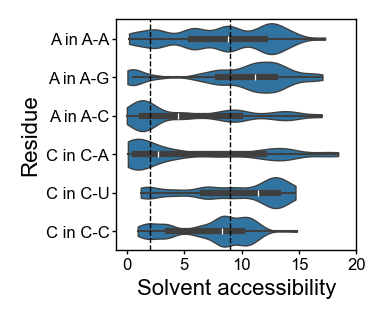

In [57]:
# get only the cats in 1x1
df_non_wc_pair = df_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair']}" if row["likely_pair"] else "",
    axis=1,
)
cats = list(df_non_wc_pair["cat"].unique())
df_non_wc_pair = df_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair']}" if row["likely_pair"] else "",
    axis=1,
)
# Filter df_non_wc_pair to only include rows where 'cat' is in cats
df_non_wc_pair = df_non_wc_pair[df_non_wc_pair["cat"].isin(cats)]
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
sns.violinplot(
    data=df_non_wc_pair,
    x="sasa_0_5",
    y="cat",
    density_norm="width",
    linewidth=0.5,
    cut=0,
    ax=ax,
)
ax.axvline(2, color="black", linestyle="--", linewidth=0.5)
ax.axvline(9, color="black", linestyle="--", linewidth=0.5)
format_small_plot(ax)
ax.set_xlabel("Solvent accessibility", labelpad=2)
ax.set_ylabel("Residue", labelpad=2)
ax.set_xticks([0, 5, 10, 15, 20])

In [58]:
print(calculate_sasa_percentages(df_non_wc_pair))

| Category   |   Percent_below_2 |   Percent_below_4 |   Percent_below_6 |   Count |
|:-----------|------------------:|------------------:|------------------:|--------:|
| A in A-A   |             10.00 |             22.86 |             33.16 | 2310.00 |
| A in A-C   |             43.54 |             49.61 |             58.52 | 2804.00 |
| A in A-G   |             14.48 |             16.77 |             17.28 | 6361.00 |
| C in C-A   |             46.92 |             55.76 |             61.27 | 2907.00 |
| C in C-C   |             10.78 |             26.22 |             29.24 | 2281.00 |
| C in C-U   |             10.89 |             17.99 |             22.18 | 2223.00 |


In [59]:
df_non_wc_pair = df_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')"
).copy()
print(len(df_non_wc_pair))
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['pdb_r_pair']}",
    axis=1,
)

print(calculate_sasa_percentages(df_non_wc_pair))

50793
| Category   |   Percent_below_2 |   Percent_below_4 |   Percent_below_6 |    Count |
|:-----------|------------------:|------------------:|------------------:|---------:|
| A in -     |              0.89 |              2.75 |              5.24 | 11630.00 |
| A in A-A   |              7.85 |             27.21 |             40.93 |  8063.00 |
| A in A-C   |             42.72 |             47.94 |             57.44 |  3769.00 |
| A in A-G   |             14.48 |             18.41 |             24.78 | 10977.00 |
| A in A-U   |              3.85 |             19.30 |             30.55 |  2674.00 |
| C in -     |              0.00 |              2.16 |              2.16 |  4713.00 |
| C in C-A   |             39.43 |             46.81 |             62.95 |  3198.00 |
| C in C-C   |             13.00 |             26.12 |             32.38 |  2684.00 |
| C in C-G   |             67.26 |             92.02 |            100.00 |   614.00 |
| C in C-U   |              5.63 |             1

## C-A / A-C pairs

In [60]:
data = []
df_sub = df_merge.query(
    "r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'C-A' and r_nuc == 'C'"
).copy()

data = []
for i, g in df_sub.groupby("m_sequence"):
    for j, group in g.groupby("pdb_path"):
        data.append(
            [
                i,
                j,
                group.iloc[0]["pdb_name"],
                group.iloc[0]["pdb_res"],
                round(group["sasa_0_5"].mean(), 2),
                round(group["r_data"].mean(), 4),
            ]
        )

headers = [
    "m_sequence",
    "pdb_path",
    "pdb_name",
    "pdb_res",
    "sasa_0_5_mean",
    "r_data_mean",
]
table = tabulate(data, headers=headers, tablefmt="pipe", numalign="left")
print(table)

| m_sequence   | pdb_path                                              | pdb_name                      | pdb_res   | sasa_0_5_mean   | r_data_mean   |
|:-------------|:------------------------------------------------------|:------------------------------|:----------|:----------------|:--------------|
| AAC_GCU      | data/pdbs_w_2bp/AAC_GCU/TWOWAY.5XXU.1-1.GCU-AAC.0.pdb | TWOWAY.5XXU.1-1.GCU-AAC.0.pdb | 3.35      | 0.98            | 0.0061        |
| AAC_GCU      | data/pdbs_w_2bp/AAC_GCU/TWOWAY.7JQC.1-1.AAC-GCU.0.pdb | TWOWAY.7JQC.1-1.AAC-GCU.0.pdb | 3.3       | 0.22            | 0.0061        |
| AAU_ACU      | data/pdbs_w_2bp/AAU_ACU/TWOWAY.1Z7F.1-1.AAU-ACU.0.pdb | TWOWAY.1Z7F.1-1.AAU-ACU.0.pdb | 2.1       | 4.06            | 0.0091        |
| AAU_ACU      | data/pdbs_w_2bp/AAU_ACU/TWOWAY.1Z7F.1-1.ACU-AAU.0.pdb | TWOWAY.1Z7F.1-1.ACU-AAU.0.pdb | 2.1       | 1.76            | 0.0091        |
| AAU_ACU      | data/pdbs_w_2bp/AAU_ACU/TWOWAY.5CCB.1-1.ACU-AAU.0.pdb | TWOWAY.5CCB.1-1.ACU-A

In [61]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'A-C' and r_nuc == 'A'"
).copy()
for i, g in df_sub.groupby("m_sequence"):
    for j, group in g.groupby("pdb_path"):
        print(
            i,
            j,
            group.iloc[0]["pdb_name"],
            group.iloc[0]["pdb_res"],
            round(group["sasa_0_5"].mean(), 2),
            round(group["r_data"].mean(), 4),
        )

AAC_GCU data/pdbs_w_2bp/AAC_GCU/TWOWAY.5XXU.1-1.GCU-AAC.0.pdb TWOWAY.5XXU.1-1.GCU-AAC.0.pdb 3.35 1.08 0.0049
AAC_GCU data/pdbs_w_2bp/AAC_GCU/TWOWAY.7JQC.1-1.AAC-GCU.0.pdb TWOWAY.7JQC.1-1.AAC-GCU.0.pdb 3.3 1.47 0.0049
AAU_ACU data/pdbs_w_2bp/AAU_ACU/TWOWAY.1Z7F.1-1.AAU-ACU.0.pdb TWOWAY.1Z7F.1-1.AAU-ACU.0.pdb 2.1 1.18 0.0048
AAU_ACU data/pdbs_w_2bp/AAU_ACU/TWOWAY.1Z7F.1-1.ACU-AAU.0.pdb TWOWAY.1Z7F.1-1.ACU-AAU.0.pdb 2.1 1.69 0.0048
AAU_ACU data/pdbs_w_2bp/AAU_ACU/TWOWAY.5CCB.1-1.ACU-AAU.0.pdb TWOWAY.5CCB.1-1.ACU-AAU.0.pdb 2.0 2.2 0.0048
AAU_ACU data/pdbs_w_2bp/AAU_ACU/TWOWAY.5D0B.1-1.ACU-AAU.0.pdb TWOWAY.5D0B.1-1.ACU-AAU.0.pdb 2.65 2.26 0.0048
ACC_GAU data/pdbs_w_2bp/ACC_GAU/TWOWAY.1TFW.1-1.ACC-GAU.0.pdb TWOWAY.1TFW.1-1.ACC-GAU.0.pdb 2.2 1.35 0.007
ACG_CAU data/pdbs_w_2bp/ACG_CAU/TWOWAY.4M4O.1-1.ACG-CAU.0.pdb TWOWAY.4M4O.1-1.ACG-CAU.0.pdb 2.0 1.14 0.0107
CAC_GCG data/pdbs_w_2bp/CAC_GCG/TWOWAY.6AGB.1-1.CAC-GCG.0.pdb TWOWAY.6AGB.1-1.CAC-GCG.0.pdb 3.48 2.09 0.006
CAC_GCG data/pdbs_w_2bp/CAC_

In [62]:
plt.scatter(df_ca["sasa_0_5"], df_ca["r_data"], s=df_ca["pdb_res"] * 20)

NameError: name 'df_ca' is not defined

## A-A pairs

In [ ]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'A-A' and r_nuc == 'A'"
).copy()
for i, g in df_sub.groupby("pdb_name"):
    for j, group in g.groupby("r_loc_pos"):
        print(
            group.iloc[0]["pdb_path"],
            group["sasa_0_5"].mean(),
            group["r_data"].mean(),
            group.iloc[0]["pdb_res"],
            group["pdb_r_bp_type"].iloc[0],
        )

data/pdbs_w_2bp/AAG_CAU/NWAY.3HOY.1-0-0-0.AAG-DA-DC-DT.0.pdb 1.9536656747585732 0.010167272727272726 3.4 cWH
data/pdbs_w_2bp/AAG_CAU/NWAY.3HOY.1-0-0-0.AAG-DA-DC-DT.0.pdb 12.874070807550307 0.012272121212121213 3.4 cWH
data/pdbs_w_2bp/GAA_UAC/NWAY.3HOY.2-0-2-0.DADA-DG-DADC-DT.0.pdb 0.7145028410809965 0.01793777777777778 3.4 cWH
data/pdbs_w_2bp/GAA_UAC/NWAY.3HOY.2-0-2-0.DADA-DG-DADC-DT.0.pdb 8.868056996922128 0.00979909090909091 3.4 cWH
data/pdbs_w_2bp/CAG_CAG/NWAY.3NJ7.4.CAGCAG.0.pdb 14.245998498694052 0.011140833333333336 1.9 cWW
data/pdbs_w_2bp/CAG_CAG/NWAY.3NJ7.4.CAGCAG.0.pdb 2.2295557411149143 0.013014583333333335 1.9 cWW
data/pdbs_w_2bp/CAG_CAG/TWOWAY.3NJ7.1-1.CAG-CAG.0.pdb 1.6309126147192243 0.011140833333333336 1.9 cWW
data/pdbs_w_2bp/CAG_CAG/TWOWAY.3NJ7.1-1.CAG-CAG.0.pdb 12.98471420809957 0.013014583333333335 1.9 cWW
data/pdbs_w_2bp/CAG_CAG/TWOWAY.4J50.1-1.CAG-CAG.0.pdb 2.3554732199813087 0.011140833333333336 1.65 cWW
data/pdbs_w_2bp/CAG_CAG/TWOWAY.4J50.1-1.CAG-CAG.0.pdb 2.50846

In [ ]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'A-G' and r_nuc == 'A'"
).copy()
for i, group in df_sub.groupby("pdb_name"):
    print(
        group.iloc[0]["pdb_path"],
        group["sasa_0_5"].mean(),
        group["r_data"].mean(),
        group.iloc[0]["pdb_res"],
        group["pdb_r_bp_type"].iloc[0],
    )

data/pdbs_w_2bp/AAU_AGU/TWOWAY.2H1M.1-1.AAU-AGU.0.pdb 0.3532454261673674 0.002926976744186047 2.9 cWH
data/pdbs_w_2bp/AAU_AGU/TWOWAY.2H1M.1-1.AGU-AAU.0.pdb 0.273277761209153 0.002926976744186047 2.9 cWH
data/pdbs_w_2bp/CAG_UGG/TWOWAY.3CUL.1-1.UGG-CAG.0.pdb 0.053817531573774 0.026122 2.8 cWW
data/pdbs_w_2bp/CAC_GGG/TWOWAY.3D0U.1-1.GGG-CAC.0.pdb 0.15238202884515598 0.003676000000000001 2.8 cWW
data/pdbs_w_2bp/CAC_GGG/TWOWAY.3DIL.1-1.GGG-CAC.0.pdb 0.15884945389638933 0.003676000000000001 1.9 cWW
data/pdbs_w_2bp/CGU_GAG/TWOWAY.4AOB.1-1.GAG-CGU.0.pdb 0.12598215067504842 0.010748387096774194 2.95 cWW
data/pdbs_w_2bp/GAC_GGC/TWOWAY.4M4O.1-1.GGC-GAC.0.pdb 0.149358312095154 0.003958421052631581 2.0 cWW
data/pdbs_w_2bp/AAU_AGU/TWOWAY.5XYI.1-1.AGU-AAU.0.pdb 0.1402725689522535 0.002926976744186047 3.35 cWW
data/pdbs_w_2bp/AGC_GAU/TWOWAY.5XYM.1-1.AGC-GAU.0.pdb 15.044322763172858 0.00432425 3.08 cWS
data/pdbs_w_2bp/AAU_AGU/TWOWAY.7LMA.1-1.AAU-AGU.0.pdb 2.6471888882889214 0.002926976744186047 3.3 cWH

In [ ]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'C-U' and r_nuc == 'C'"
).copy()
for i, group in df_sub.groupby("pdb_name"):
    print(
        i,
        group["sasa_0_5"].mean(),
        group["r_data"].mean(),
        group.iloc[0]["pdb_res"],
        group["pdb_r_bp_type"].iloc[0],
    )

NWAY.3PO2.1-0-0-0.CCC-DG-DG-DT.0.pdb 2.087592683608341 0.005887567567567568 3.3 cWW
NWAY.3PO3.1-0-0-0.CCC-DG-DG-DT.0.pdb 3.933190489234728 0.005887567567567568 3.3 cWW
NWAY.4BXX.1-0-0-0.CCC-DG-DG-DT.0.pdb 3.719580136942005 0.005887567567567568 3.2800000000000002 cWW
TWOWAY.3J7A.1-1.AUG-CCU.0.pdb 4.715076035089728 0.005238333333333334 3.2 cWW
TWOWAY.3J7A.1-1.AUG-CCU.1.pdb 7.297444038927894 0.005238333333333334 3.2 cWW
TWOWAY.3J7A.1-1.UUG-CCG.0.pdb 9.038545031959922 0.007079 3.2 cWW
TWOWAY.3RW6.1-1.CCG-CUG.1.pdb 8.68869240325242 0.011069024390243903 2.3 cWW
TWOWAY.4JYA.1-1.CCC-GUG.0.pdb 10.169140797881363 0.005887567567567568 3.1 cWW
TWOWAY.5XYI.1-1.ACA-UUU.0.pdb 5.734666124004946 0.0073366666666666676 3.35 cWW
TWOWAY.6OKK.1-1.AUG-CCU.0.pdb 4.556567477782686 0.005238333333333334 3.3 cWW
TWOWAY.6OKK.1-1.AUG-CCU.1.pdb 7.284497697748328 0.005238333333333334 3.3 cWW
TWOWAY.6OKK.1-1.UUG-CCG.0.pdb 9.040921373949793 0.007079 3.3 cWW
TWOWAY.6QKL.1-1.AUU-ACU.0.pdb 10.702216994526092 0.00933484848

In [ ]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and m_token == '2x2' and pdb_r_pair == 'C-A' and r_nuc == 'C'"
).copy()
for i, group in df_sub.groupby("pdb_name"):
    print(
        i,
        group["sasa_0_5"].mean(),
        group["r_data"].mean(),
        group.iloc[0]["pdb_res"],
        group["pdb_r_bp_type"].iloc[0],
    )

NWAY.3WBM.6.ACCCGACU.0.pdb 8.740709203939868 0.01057701030927835 2.0 cWW
TWOWAY.1D4R.2-2.GACC-GACC.0.pdb 0.3017339545880133 0.005209901960784314 2.0 cWW
TWOWAY.1D4R.2-2.GACC-GACC.1.pdb 1.7181679755195411 0.005209901960784314 2.0 cWW
TWOWAY.1JID.2-2.GACC-GACC.0.pdb 0.2477011448206924 0.005209901960784314 1.8 cWW
TWOWAY.1L9A.2-2.GACC-GACC.0.pdb 4.64816036929303 0.005209901960784314 2.9 cWW
TWOWAY.1MFQ.2-2.GACC-GACC.0.pdb 1.1870182065029717 0.005209901960784314 3.1 cWW_p
TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb 1.2254601982971158 0.01057701030927835 2.0 cWW
TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb 11.038183641709505 0.09397474747474749 3.0 cWW


In [ ]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and m_token == '2x2' and pdb_r_pair == 'A-C'"
).copy()
for i, group in df_sub.groupby("pdb_name"):
    print(
        i,
        group["sasa_0_5"].mean(),
        group["r_data"].mean(),
        group["r_nuc"].iloc[0],
        group["pdb_r_pair"].iloc[0],
        group["pdb_r_bp_type"].iloc[0],
    )

NWAY.3WBM.6.ACCCGACU.0.pdb 4.898237388847142 0.014182708333333335 A A-C cWW
TWOWAY.1D4R.2-2.GACC-GACC.0.pdb 0.9434917050161884 0.008373069306930695 A A-C cWW
TWOWAY.1D4R.2-2.GACC-GACC.1.pdb 1.5214286676358988 0.008373069306930695 A A-C cWW
TWOWAY.1JID.2-2.GACC-GACC.0.pdb 1.5463107768249107 0.008373069306930695 A A-C cWW
TWOWAY.1L9A.2-2.GACC-GACC.0.pdb 5.738047336482765 0.008373069306930695 A A-C cWW
TWOWAY.1MFQ.2-2.GACC-GACC.0.pdb 2.9549808953660457 0.008373069306930695 A A-C cWW_p
TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb 0.5519224524026525 0.014182708333333335 A A-C cWW
TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb 1.7970474593716503 0.0038811000000000006 A A-C cWW


## outliers?

### low SASA high reactivity

In [ ]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and r_nuc == 'A' and r_data > 0.02 and sasa_0_5 < 5"
).copy()
for i, group in df_sub.groupby("pdb_name"):
    print(
        group.iloc[0]["pdb_path"],
        group["sasa_0_5"].mean(),
        group["r_data"].mean(),
        group.iloc[0]["pdb_res"],
        group["pdb_r_bp_type"].iloc[0],
    )

data/pdbs_w_2bp/CAUAG_CG/NWAY.2GJW.0-0-0-0.CA-AG-DU-CG.0.pdb 4.045538202860776 0.06570578313253013 2.85 cSS
data/pdbs_w_2bp/GGAC_GGAC/NWAY.3CJZ.1--1-0--1-0-1.M2G-G-AC-G-AC-M2G.0.pdb 0.981161410369234 0.0224 1.8 cWW
data/pdbs_w_2bp/GAA_UAC/NWAY.3HOY.2-0-2-0.DADA-DG-DADC-DT.0.pdb 0.7145028410809965 0.025218 3.4 cWH
data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU.0.pdb 4.898237388847141 0.0211525 2.0 cWW
data/pdbs_w_2bp/CUAAG_UAUG/NWAY.4PCJ.1-2-0.AAG-UAUG-CU.0.pdb 2.387773205562694 0.026997 1.9 cSH
data/pdbs_w_2bp/CUAAG_UAUG/NWAY.5VCI.1-0-2.AAG-CU-UAUG.0.pdb 2.3504087464214867 0.026997 2.6 cSH
data/pdbs_w_2bp/AAGGAA_UGU/NWAY.6E8U.0-1-2.AA-UGU-AAGG.0.pdb 4.011066823847514 0.022895161290322583 1.55 cWW
data/pdbs_w_2bp/GAAG_CCC/NWAY.7C7L.1-1--1.AAG-CCC-G.0.pdb 0.525768995914226 0.0634202564102564 3.3 cWS
data/pdbs_w_2bp/CUAAG_UAUG/TWOWAY.1KXK.3-2.CUAAG-UAUG.0.pdb 1.8082615947778544 0.021920000000000002 3.0 cSH
data/pdbs_w_2bp/GAGAAC_GAC/TWOWAY.1NJP.4-1.GAGAAC-GAC.0.pdb 2.0648691141725015 0.02

In [ ]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and r_nuc == 'C' and r_data > 0.02 and sasa_0_5 < 5"
).copy()
for i, group in df_sub.groupby("pdb_name"):
    print(
        group.iloc[0]["pdb_path"],
        group["sasa_0_5"].mean(),
        group["r_data"].mean(),
        group.iloc[0]["pdb_res"],
        group["pdb_r_bp_type"].iloc[0],
    )

data/pdbs_w_2bp/CCCG_CCCG/NWAY.5EW4.0-0-2.CG-CC-CCCG.0.pdb 1.8130848025156288 0.04029444444444445 1.47 cWW
data/pdbs_w_2bp/CCCG_CCCG/NWAY.5EW4.2-0-0.CCCG-CG-CC.0.pdb 2.1672423185206338 0.04029444444444445 1.47 cWW
data/pdbs_w_2bp/UCACAG_UCACAG/TWOWAY.1KD4.4-4.UCACAG-UCACAG.0.pdb 0.6069353811179496 0.04131403846153846 1.85 cWH
data/pdbs_w_2bp/UCACAG_UCACAG/TWOWAY.1KD5.4-4.UCACAG-UCACAG.0.pdb 2.6291726878346373 0.04131403846153846 1.58 cWH
data/pdbs_w_2bp/ACU_ACU/TWOWAY.1YZ9.1-1.ACU-ACU.0.pdb 2.4652953778556803 0.02305666666666667 2.1 cWW
data/pdbs_w_2bp/GUAAC_GCCC/TWOWAY.3LOA.2-3.GCCC-GUAAC.0.pdb 4.488980327900647 0.03622950980392157 2.8 cWW
data/pdbs_w_2bp/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb 3.5807625785329296 0.025070694444444444 2.0 cWW
data/pdbs_w_2bp/CCG_CCG/TWOWAY.4E59.1-1.CCG-CCG.0.pdb 4.4002610355444585 0.03417545454545455 1.54 cWW
data/pdbs_w_2bp/CCG_CCG/TWOWAY.4IOA.1-1.CCG-CCG.0.pdb 2.3182458438670803 0.035772083333333336 3.2 cWW
data/pdbs_w_2bp/CCG_UCG/TWOWAY.4IOA.1-1.U

In [ ]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and r_data > 0.02 and sasa_0_5 < 5 and pdb_res < 2.5"
).copy()
for i, group in df_sub.groupby("pdb_name"):
    print(
        group.iloc[0]["pdb_path"],
        group["sasa_0_5"].mean(),
        group["r_data"].mean(),
        group.iloc[0]["pdb_res"],
        group["pdb_r_bp_type"].iloc[0],
    )

data/pdbs_w_2bp/GGAC_GGAC/NWAY.3CJZ.1--1-0--1-0-1.M2G-G-AC-G-AC-M2G.0.pdb 0.981161410369234 0.0224 1.8 cWW
data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU.0.pdb 4.898237388847141 0.0211525 2.0 cWW
data/pdbs_w_2bp/CUAAG_UAUG/NWAY.4PCJ.1-2-0.AAG-UAUG-CU.0.pdb 2.387773205562694 0.026997 1.9 cSH
data/pdbs_w_2bp/CCCG_CCCG/NWAY.5EW4.0-0-2.CG-CC-CCCG.0.pdb 1.8130848025156288 0.04029444444444445 1.47 cWW
data/pdbs_w_2bp/CCCG_CCCG/NWAY.5EW4.2-0-0.CCCG-CG-CC.0.pdb 2.1672423185206338 0.04029444444444445 1.47 cWW
data/pdbs_w_2bp/AAGGAA_UGU/NWAY.6E8U.0-1-2.AA-UGU-AAGG.0.pdb 4.011066823847514 0.022895161290322583 1.55 cWW
data/pdbs_w_2bp/UCACAG_UCACAG/TWOWAY.1KD4.4-4.UCACAG-UCACAG.0.pdb 0.6069353811179496 0.04131403846153846 1.85 cWH
data/pdbs_w_2bp/UCACAG_UCACAG/TWOWAY.1KD5.4-4.UCACAG-UCACAG.0.pdb 2.6291726878346373 0.04131403846153846 1.58 cWH
data/pdbs_w_2bp/ACU_ACU/TWOWAY.1YZ9.1-1.ACU-ACU.0.pdb 2.4652953778556803 0.02305666666666667 2.1 cWW
data/pdbs_w_2bp/GAUGG_CAC/TWOWAY.3MXH.1-3.CAC-GAUGG.0.pd

### high SASA low reactivity

In [ ]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and r_data < 0.01 and sasa_0_5 > 15 and pdb_res < 2.5"
).copy()
for i, group in df_sub.groupby("pdb_name"):
    print(
        group.iloc[0]["pdb_path"],
        group["sasa_0_5"].mean(),
        group["r_data"].mean(),
        group.iloc[0]["pdb_res"],
        group["pdb_r_bp_type"].iloc[0],
    )

data/pdbs_w_2bp/UAA_UA/NWAY.1I9X.-1--1-1.A-U-UAA.0.pdb 17.49867519774649 0.00609 2.18 lone_flipped_out
data/pdbs_w_2bp/UAA_UA/NWAY.1I9X.1--1--1.UAA-A-U.0.pdb 17.082210267014382 0.00609 2.18 lone_flipped_out
data/pdbs_w_2bp/GAUGAAA_UAACC/NWAY.5XTM.3-3-0.UGAAA-UAACC-GA.0.pdb 17.34780071022387 0.0077625 2.1 lone_flipped_out
data/pdbs_w_2bp/AAGGAA_UGU/NWAY.6E8U.0-1-2.AA-UGU-AAGG.0.pdb 17.19775163070048 0.007912881355932204 1.55 lone_flipped_out
data/pdbs_w_2bp/GAC_GC/TWOWAY.1CSL.0-1.GC-GAC.0.pdb 17.27670731756154 0.00837 1.6 lone_flipped_out
data/pdbs_w_2bp/GAC_GC/TWOWAY.1DUQ.0-1.GC-GAC.0.pdb 17.064605436192345 0.00837 2.1 lone_flipped_out
data/pdbs_w_2bp/GAC_GC/TWOWAY.1DUQ.0-1.GC-GAC.1.pdb 17.167747716614397 0.00837 2.1 lone_flipped_out
data/pdbs_w_2bp/GAC_GC/TWOWAY.1DUQ.0-1.GC-GAC.2.pdb 17.172411714512023 0.00837 2.1 lone_flipped_out
data/pdbs_w_2bp/GAC_GC/TWOWAY.1DUQ.0-1.GC-GAC.3.pdb 17.222606446209397 0.00837 2.1 lone_flipped_out
data/pdbs_w_2bp/UAC_GA/TWOWAY.1JZV.0-1.GA-UAC.0.pdb 17.0

In [ ]:
df_sub = df_merge.query(
    "r_type == 'NON-WC' and m_token == '3x3' and pdb_r_pair == 'A-C'"
).copy()
for i, group in df_sub.groupby("pdb_name"):
    print(
        i,
        group["sasa_0_5"].mean(),
        group["r_data"].mean(),
        group["r_nuc"].iloc[0],
        group["pdb_r_pair"].iloc[0],
        group["pdb_r_bp_type"].iloc[0],
    )

TWOWAY.2R8S.3-3.CCAAG-UGCAG.0.pdb 9.648667157564347 0.02876582524271845 A A-C tSH


In [ ]:
def create_heatmap(df, ln_r_data_col, sasa_col, bins=10):
    """
    Creates and displays a heatmap using the specified columns from the dataframe with binning.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    ln_r_data_col (str): The column name for ln_r_data.
    sasa_col (str): The column name for sasa.
    bins (int): The number of bins to use for binning the continuous data.
    """
    # Create bins for the continuous data
    df["ln_r_data_binned"] = pd.cut(df[ln_r_data_col], bins=bins)
    df["sasa_binned"] = pd.cut(df[sasa_col], bins=bins)

    # Create a pivot table
    pivot_table = df.pivot_table(
        index="ln_r_data_binned", columns="sasa_binned", aggfunc="size", fill_value=0
    )

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, cmap="viridis", annot=True, fmt="d")
    plt.title("Heatmap of ln_r_data vs sasa")
    plt.xlabel(sasa_col)
    plt.ylabel(ln_r_data_col)
    plt.show()

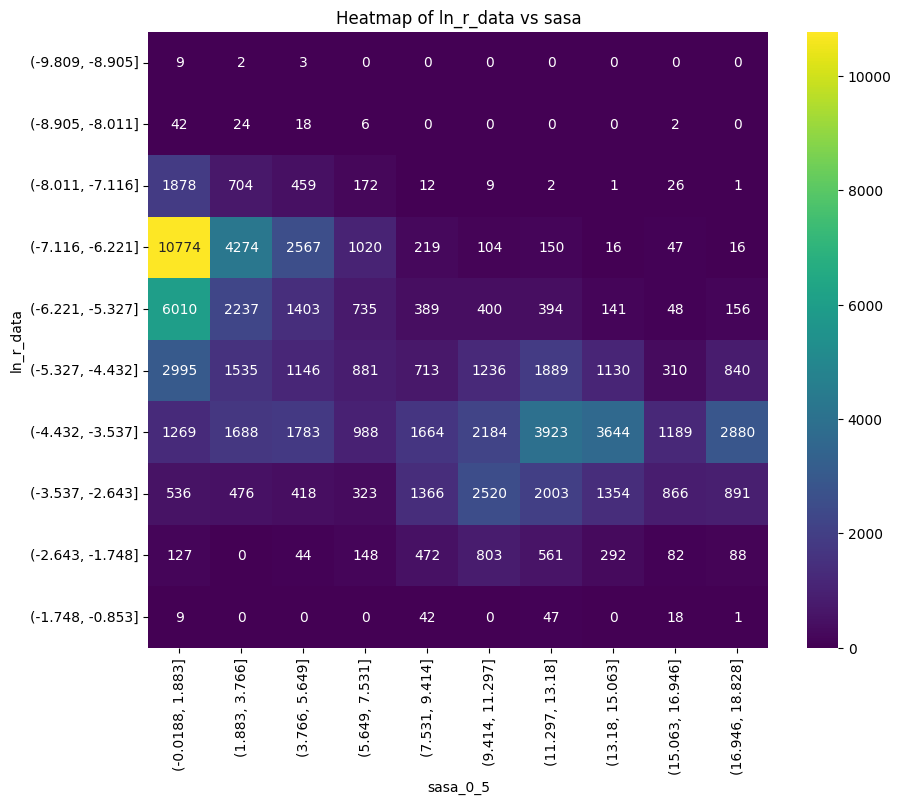

In [ ]:
create_heatmap(df_merge, "ln_r_data", "sasa_0_5", bins=10)

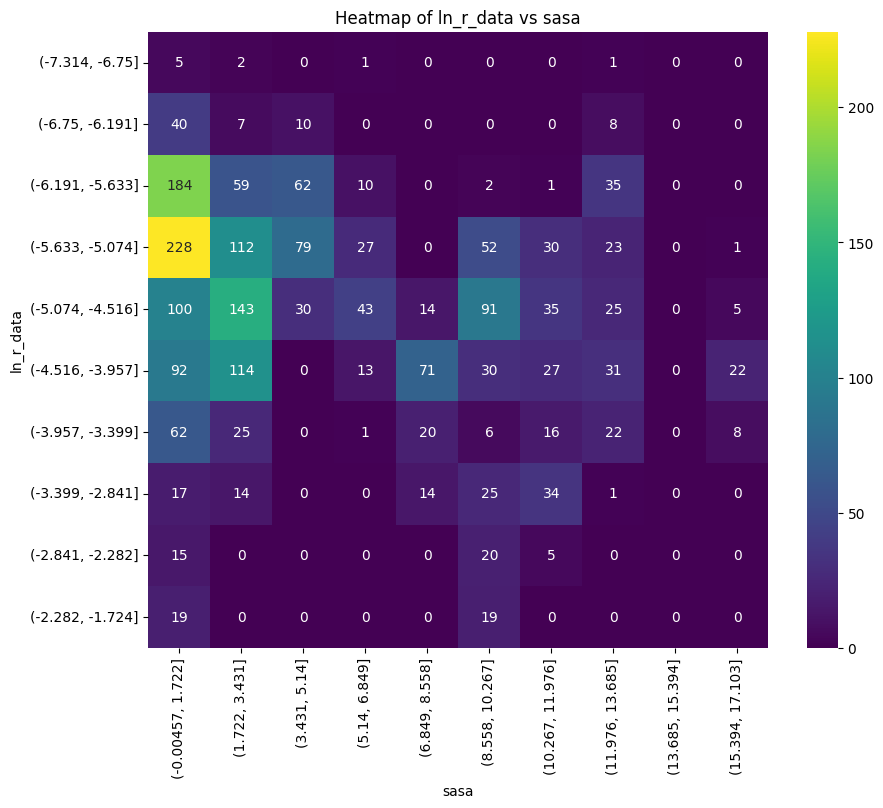

In [ ]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1'").copy()
create_heatmap(df_sub, "ln_r_data", "sasa", bins=10)

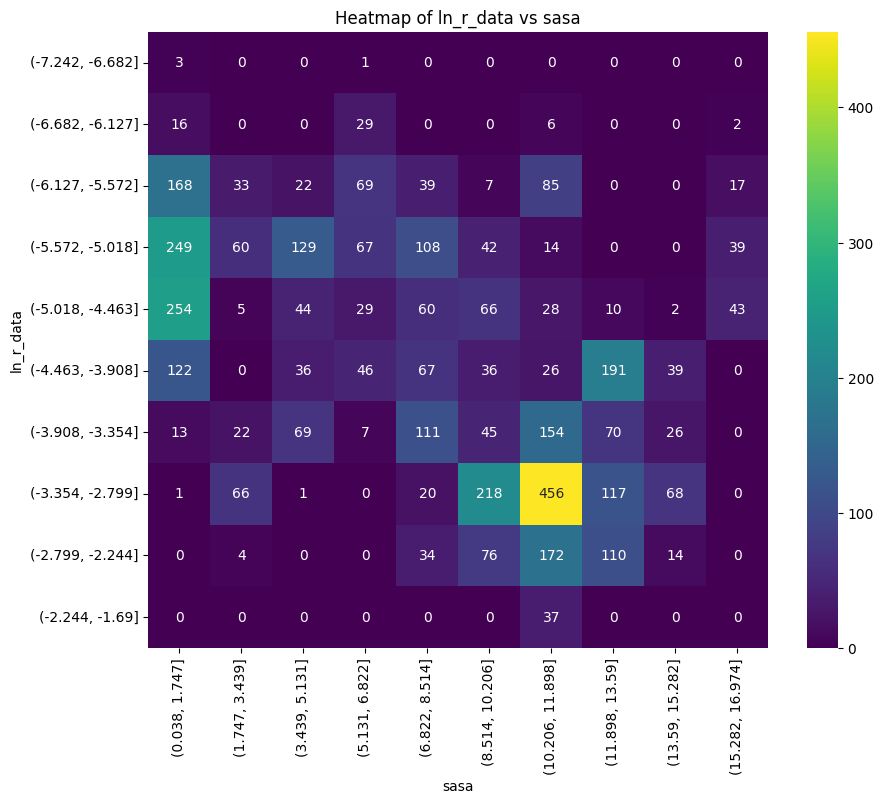

In [ ]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '2x2'").copy()
create_heatmap(df_sub, "ln_r_data", "sasa", bins=10)

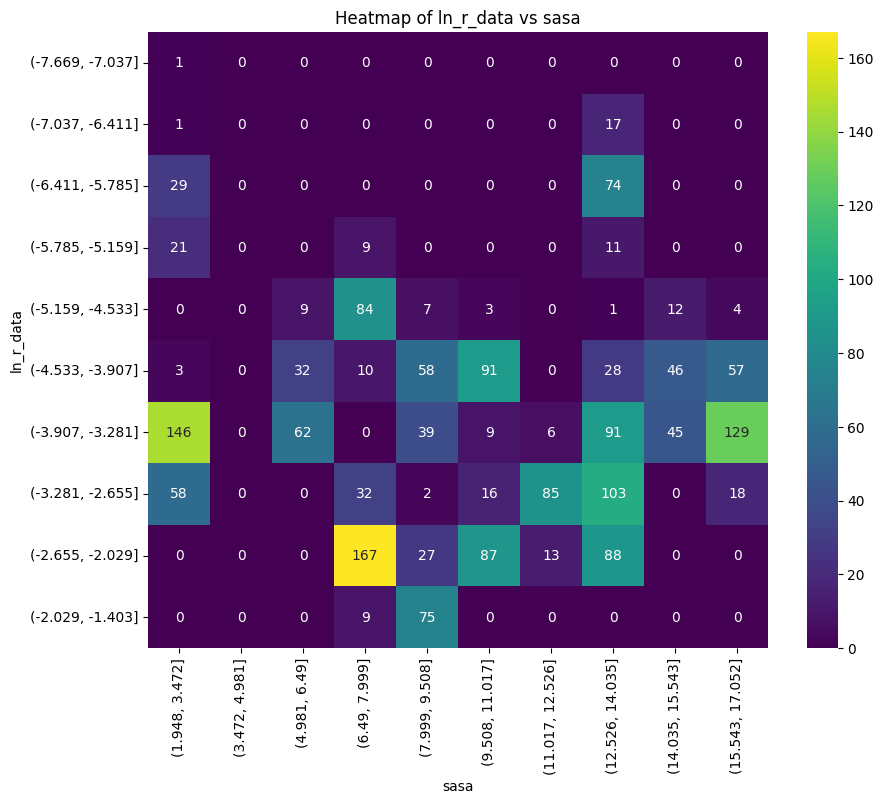

In [ ]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '3x3'").copy()
create_heatmap(df_sub, "ln_r_data", "sasa", bins=10)

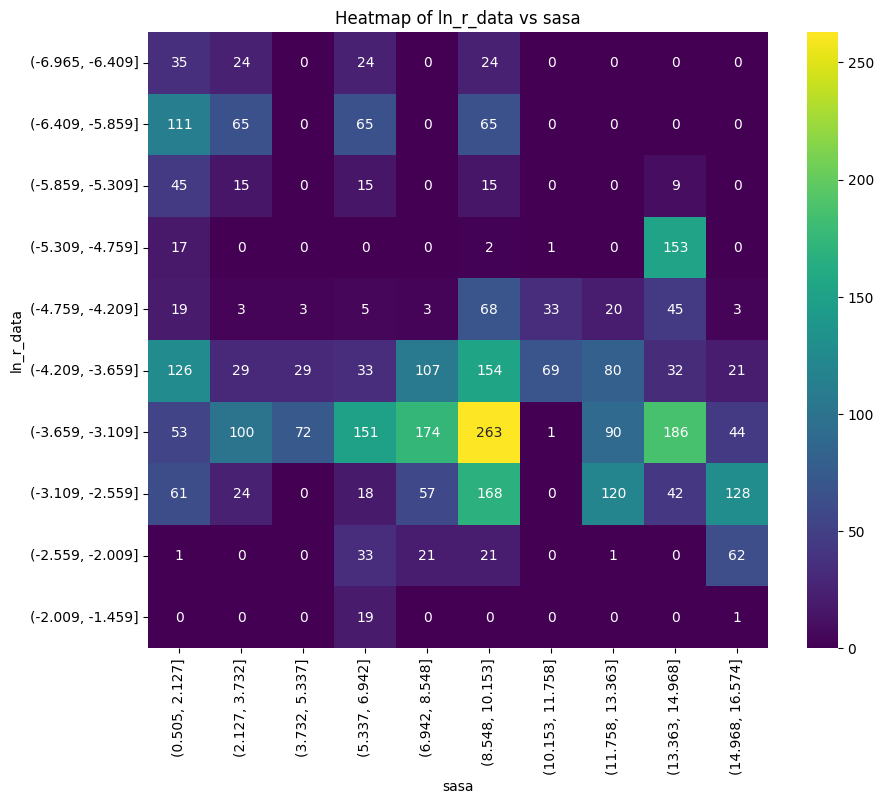

In [ ]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '4x4'").copy()
create_heatmap(df_sub, "ln_r_data", "sasa", bins=10)

<Axes: xlabel='sasa_0_5', ylabel='m_token'>

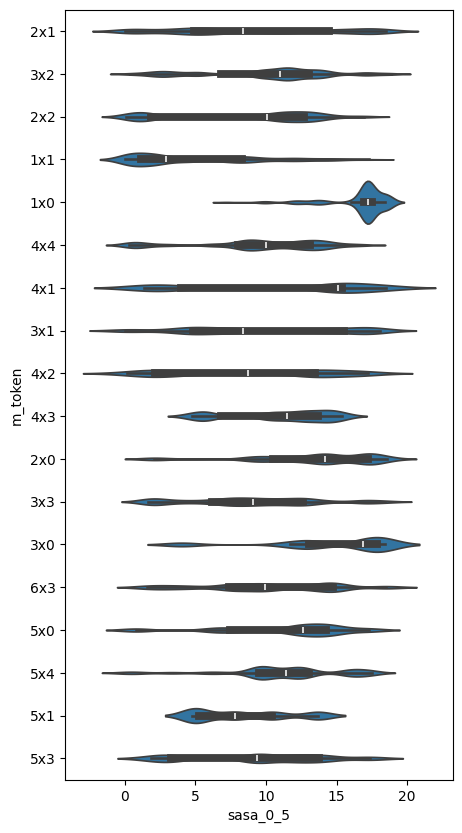

In [ ]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.violinplot(data=df_non_wc, x="sasa_0_5", y="m_token", width=1.0, ax=ax)

<Axes: xlabel='sasa_0_5', ylabel='likely_pair'>

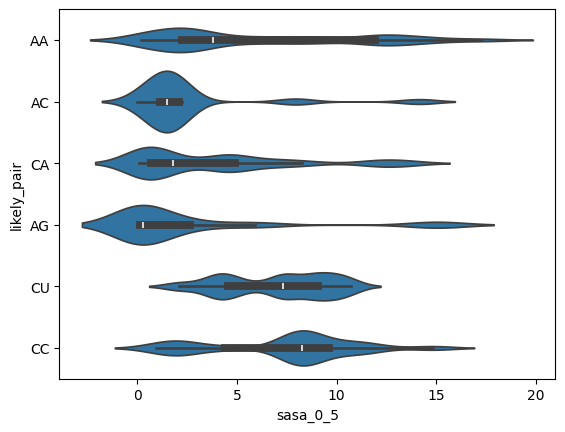

In [ ]:
df_sub = df_non_wc.query("m_token == '1x1'").copy()
sns.violinplot(data=df_sub, x="sasa_0_5", y="likely_pair", width=1.0)

<Axes: xlabel='sasa', ylabel='likely_pair'>

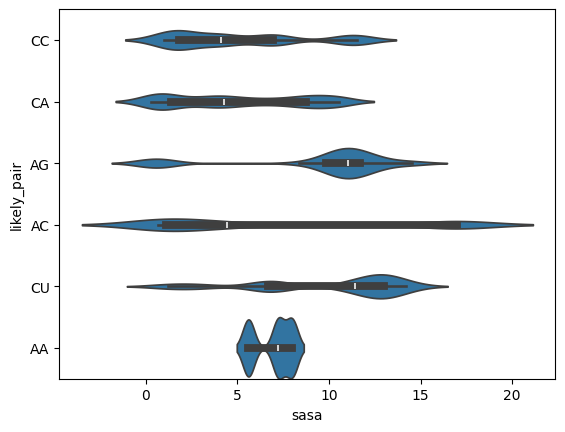

In [ ]:
df_sub = df_non_wc.query("m_token == '2x2'").copy()
sns.violinplot(data=df_sub, x="sasa", y="likely_pair", width=1.0)

<Axes: xlabel='ln_r_data', ylabel='likely_pair'>

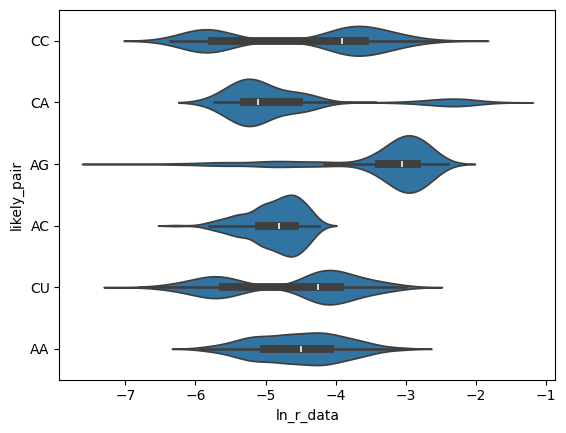

In [ ]:
df_sub = df_non_wc.query("m_token == '2x2'").copy()
sns.violinplot(data=df_sub, x="ln_r_data", y="likely_pair", width=1.0)

<Axes: xlabel='sasa', ylabel='likely_pair'>

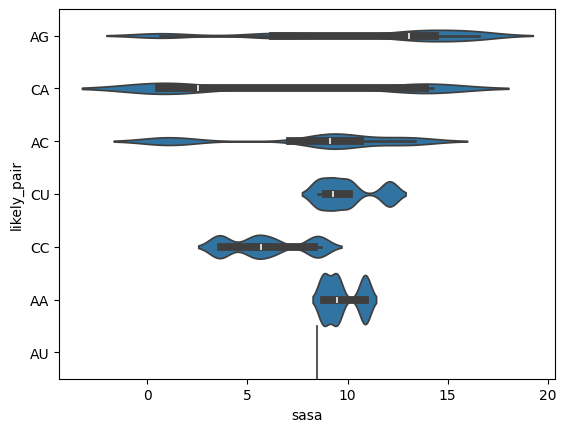

In [ ]:
df_sub = df_non_wc.query("m_token == '4x4'").copy()
sns.violinplot(data=df_sub, x="sasa", y="likely_pair", width=1.0)

<Axes: xlabel='ln_r_data', ylabel='likely_pair'>

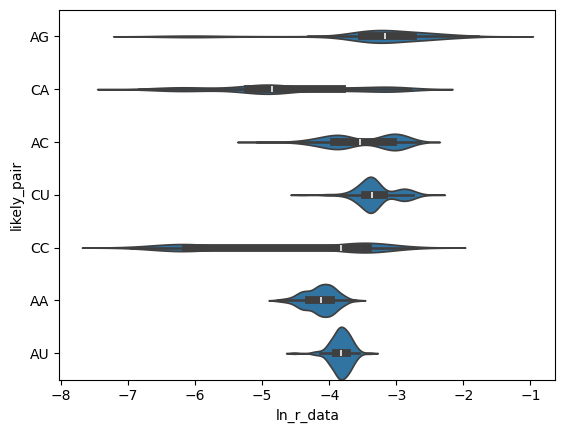

In [ ]:
df_sub = df_non_wc.query("m_token == '4x4'").copy()
sns.violinplot(data=df_sub, x="ln_r_data", y="likely_pair", width=1.0)